# Text Classification using BERT Models
I created this project to classify labeled text data. My main motivation in this project was to try and use the most recent models in a text classification setting. 

Previously, I created a supervised learning chatbot for answering general questions for a deliveree company. The chatbot used a combination of hyperparameter-tuned random forest and expert system to answer questions. The resulting questions was answered with a predetermined text and links redirecting the consumers to web pages containing the answers to their questions.

This chatbot was, and is, useful. It currently has 80-85% accuracy in answering consumers' questions. However, the expert system made it answer certain questions wrong. 

So, this text classification project is one of my ways to research whether I can completely replace the expert system with a machine learning model and obtaining higher prediction accuracy compared to the combo random forest-expert system model.

Also, this project will serve as a bridge to get my knowledge to a higher level so that someday I can leverage LLMs to create an "unsupervised learning" chatbot where consumers can ask questions and the chatbot will retrieve the answer from its knowledge database and give "ChatGPT-like" answers to the questions. That would be the end goal.

### The libraries
Mainly, I'm going to use a combination of transformers by hugging face library and pytorch to create, train, validate, and create a prediction pipeline for production. I'm going to use BERT models (including DistilBert) to compare the accuracy. I need to see how long the training phase is, and judge whether the time spent training (and of course, retraining), is worth it.

### The dataset
Obviously, I cannot use the shipping company's chat data to do this project, since it's highly classified. So, I will use the consumers' complaint database from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database) since it has similar columns. 

In this dataset, I will try to classify consumers' complaint narrative to its product. This is going to be pretty similar with classifying consumers' chats to their intents.

In [110]:
#standard librares
import re
import torch
import pickle
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import sys

#appending src directory
sys.path.append('../src')

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from wordcloud import WordCloud

#pytorch libraries
import torch
import torch.nn as nn
import torch.optim

#transformers libraries
from transformers import BertModel
from transformers import BertTokenizer

#scikit-learn libraries
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#helper functions
import helper

random.seed(42)

In this project, I will go ahead and create the functions I need. These functions will be saved into a separate .py files to modularize it, and to use it later if needed.

In [3]:
def save_file(name, obj):
    """
    Function to save an object as pickle file
    """
    with open(name, 'wb') as f:
        pickle.dump(obj, f)


def load_file(name):
    """
    Function to load a pickle object
    """
    return pickle.load(open(name, "rb"))

In [4]:
def create_bar_chart(df,col,rotation=0):
    """
    Function to create a barchart
    
    INPUT
    :df: the pandas dataframe of interest
    :col: the column of interest, the datatype is string
    :rotation: how many degrees of rotation for the x-axis names if neccessary. Default is 0
    
    OUTPUT
    None. The function only shows the plot. 
    """
    value_counts_series = df[col].value_counts()

    # Create a bar chart using Seaborn
    sns.barplot(x=value_counts_series.index, y=value_counts_series.values)

    # Add labels and title
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Count')
    plt.title('Distribution of ' + col.replace('_',' ').title())

    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show();

First of all, I will determine the path to the files I'm going to need for later. These are the tokens, labels, data, models I trained, and the label encoder path.

In [51]:
tokens_path = "../output/tokens.pkl"
labels_path = "../output/labels.pkl"
data_path = "../data/complaints.csv"
model_path = "../output/bert_pre_trained.pth"
label_encoder_path = "../output/label_encoder.pkl"

## Initial look at the data
Here is the dataset that I'm using for this project.

In [52]:
df = pd.read_csv(data_path)

In [53]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


I'm not going to use all the columns. I will only use the Consumer complaint narrative column as the text column and the Product as the label column.

In [54]:
df = df[['Consumer complaint narrative', 'Product']]

In [9]:
df.shape

(2326246, 2)

The data has 2,326,246 rows and 2 columns. I have to check for the null values for these columns. I won't be able to use those with missing data.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326246 entries, 0 to 2326245
Data columns (total 2 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Consumer complaint narrative  object
 1   Product                       object
dtypes: object(2)
memory usage: 35.5+ MB


Next, I will convert the columns into lowercase and snake case to make it easier for me to call them later.

In [55]:
df.columns = helper.clean_columns(df.columns)
df.columns

Index(['consumer_complaint_narrative', 'product'], dtype='object')

In [56]:
target_col = 'product'
text_col = 'consumer_complaint_narrative'

## Checking for null values
Again, I won't be able to use rows with null values here. So, I need to check whether there are missing values in the dataset.

In [57]:
df.isnull().sum()

consumer_complaint_narrative    1516903
product                               0
dtype: int64

In [58]:
print(f"There are {df.isnull().sum().sum()/df.shape[0]*100}% of missing data in the dataframe.")

There are 65.20819380237516% of missing data in the dataframe.


Apparently, there are lots of missing values here. More than 65% of the rows contain missing values. However, the product column doesn't have one, so it's safe to drop the missing values with the text column as the subset.

In [59]:
df.dropna(subset=[text_col], inplace=True)

In [60]:
df.shape

(809343, 2)

After dropping the missing values, I have 809,343 rows. It's still quite a lot, so I can continue this project.

## Checking the label column
Next, I will check the values in the label column. This is to determine whether I can simplify this column or not.

In [61]:
df['product'].value_counts()

product
Credit reporting, credit repair services, or other personal consumer reports    316465
Debt collection                                                                 157381
Mortgage                                                                         84461
Credit card or prepaid card                                                      60754
Checking or savings account                                                      37389
Credit reporting                                                                 31588
Student loan                                                                     29094
Credit card                                                                      18838
Money transfer, virtual currency, or money service                               18583
Vehicle loan or lease                                                            15034
Bank account or service                                                          14885
Payday loan, title loan, or persona

Apparently, I need to map the values in the product column because there are a lot of overlapping values. For example, "Credit reporting, credit repair services, or other personal consumer reports" is a value in the column. However, I believe that "Credit reporting" is a part of the previous value. Therefore, I will simplify the column values.

In [62]:
#create a mapping dictionary
product_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "credit_reporting",
    "Debt collection": "debt_collection",
    "Mortgage": "mortgage",
    "Credit reporting": "credit_reporting",
    "Credit card or prepaid card": "credit_prepaid_card",
    "Checking or savings account": "bank_account",
    "Credit card": "credit_prepaid_card",
    "Bank account or service": "bank_account",
    "Student loan": "personal_loan",
    "Money transfer, virtual currency, or money service": "money_transfer",
    "Consumer Loan": "consumer_loan",
    "Vehicle loan or lease": "personal_loan",
    "Payday loan, title loan, or personal loan": "personal_loan",
    "Payday loan": "personal_loan",
    "Money transfers": "money_transfer",
    "Prepaid card": "credit_prepaid_card",
    "Other financial service": "others",
    "Virtual currency": "money_transfer"
}

In [63]:
#using the product mapping to replace the values
df.replace({target_col:product_mapping}, inplace=True)

In [64]:
df['product'].value_counts()

product
credit_reporting       348053
debt_collection        157381
mortgage                84461
credit_prepaid_card     81042
personal_loan           56274
bank_account            52274
money_transfer          20096
consumer_loan            9470
others                    292
Name: count, dtype: int64

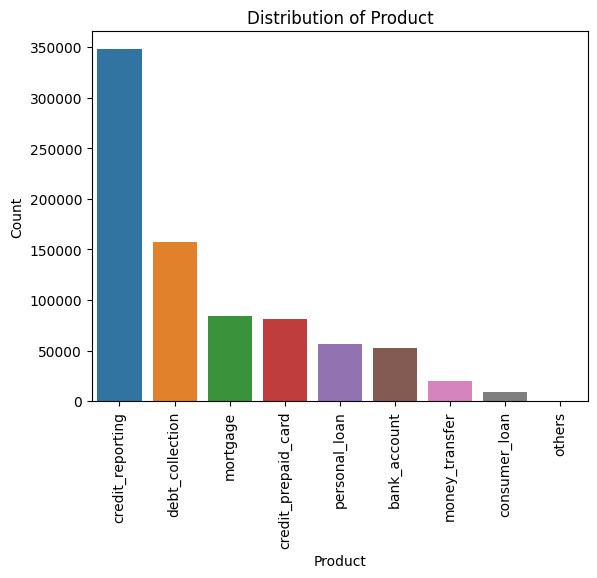

In [65]:
helper.create_bar_chart(df,'product',rotation=90)

The target column looks cleaner. From the bar chart, the number of complaints regarding credit_reporting is the highest, followed by debt_collection and mortgage. The least is others, which is undefined.

## Cleaning the text column
Next, I will clean the text column. I need to check the values in it.

In [66]:
df[text_col].head(100)

1      I contacted Ally on Friday XX/XX/XXXX after fa...
7      Hello This complaint is against the three cred...
8      I am a victim of Identity Theft & currently ha...
10     Two accounts are still on my credit history af...
13     Receiving daily telephone call ( s ) from XXXX...
                             ...                        
233    CIT Bank charged me $ XXXX for closing a CD ( ...
235    THIS COMPANY HAS REPORTED A NEGATIVE AND INVAL...
236    I attended XXXX XXXX University from the fall ...
242    XXXX sold their XXXX  accounts to Citibank. Wh...
243    On or around XX/XX/XXXX I received a call from...
Name: consumer_complaint_narrative, Length: 100, dtype: object

Based on the data, I will perform these cleaning steps:
1. Deal with consecutive Xs (see row index 1 and 243 as examples).
2. Remove special characters apart from apostrophe. This is because as far as I know, BERT's subword tokenization can deal with negatives, which often contains apostrophes.
3. Replacing digits. I don't think the digits are necessary in this text classification project.
4. Replacing double spaces with the single ones. The double spaces will be the result of substituting certain parts of the text such as digits.

In [67]:
df[text_col] = df[text_col].str.lower()
tqdm.pandas()
patterns = [r'[Xx]{2,}', r"[^\w\d'\s]+", "\d+", ' +']
pattern_identifier = ['Dealing with consecutive Xs', 'Removing special characters apart from apostrophe', 'Replacing digits', 'Replacing double spaces with single ones']

In [68]:
for i, pattern in enumerate(patterns):
    print(pattern_identifier[i])
    df[text_col] = df[text_col].progress_apply(lambda text: helper.replace_pattern(pattern, text))

Dealing with consecutive Xs


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:08<00:00, 99958.41it/s]


Removing special characters apart from apostrophe


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:24<00:00, 33181.33it/s]


Replacing digits


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:15<00:00, 53316.24it/s]


Replacing double spaces with single ones


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:28<00:00, 28566.09it/s]


In [69]:
df[text_col].head(100)

1      i contacted ally on friday xx xx xxxx after fa...
7      hello this complaint is against the three cred...
8      i am a victim of identity theft currently have...
10     two accounts are still on my credit history af...
13     receiving daily telephone call s from xxxx xxx...
                             ...                        
233    cit bank charged me xxxx for closing a cd mont...
235    this company has reported a negative and inval...
236    i attended xxxx xxxx university from the fall ...
242    xxxx sold their xxxx accounts to citibank when...
243    on or around xx xx xxxx i received a call from...
Name: consumer_complaint_narrative, Length: 100, dtype: object

I will create a function to do the cleaning for the future, also another function to do just an input text cleaning. The steps are exactly the same as what I created above.

Since the data is cleaned, I will proceed to prepare for the model training phase.

## Creating wordcloud

In [27]:
#join the cleaned text
text = " ".join(sent for sent in df[text_col])
print("There are {} words in the text.".format(len(text)))

There are 776427144 words in the text.


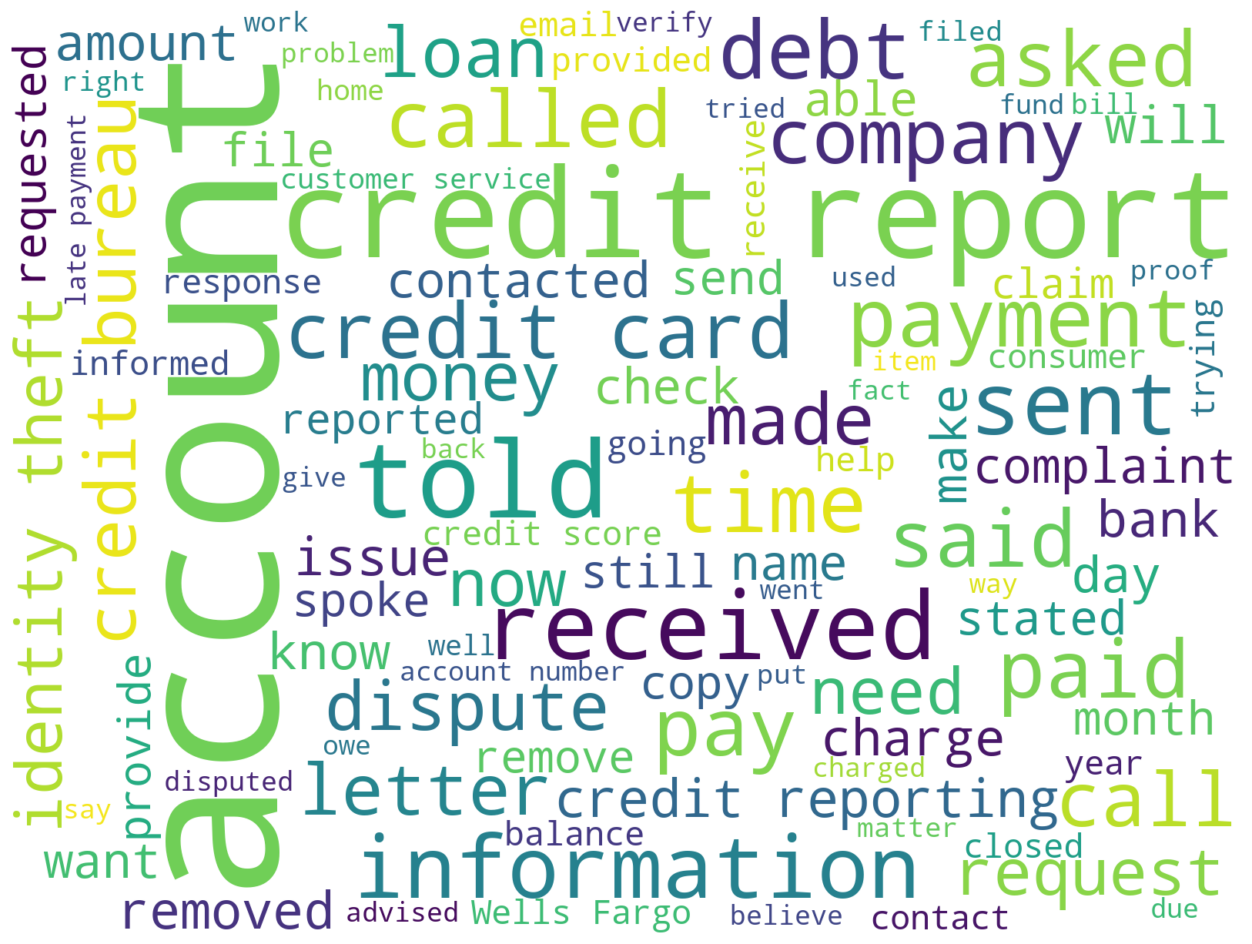

In [28]:
wordcloud = WordCloud(background_color = "white", height=1200, width= 1600, collocations=True , max_words= 100).generate(text)
plt.figure(figsize= (16,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Tokenizing the text column
The first step is to tokenize the text column. I will use the pre-trained bert-base-uncased tokenizer since I've converted all the text in the text columns into lowercase. In this project, I don't think that the text is more important if I pay attention to the uppercase and lowercase.

I will tokenize the text column with max_length padding, and predetermie the max_length to 20. The return tensors will be PyTorch tensors since I'm going to use PyTorch in this project.

In [30]:
#loading pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [31]:
#tokenizing the text column
seq_len = 20
tokens = [tokenizer(i, padding="max_length", max_length=seq_len, 
                    truncation=True, return_tensors="pt") 
         for i in df[text_col].tolist()]

In [33]:
#saving the tokens
helper.save_file(tokens_path, tokens)

In [92]:
type(tokens[0])

transformers.tokenization_utils_base.BatchEncoding

## Creating classes
There are 2 classes that I'm going to create. The first one is the model, and the other is for initializing PyTorch dataset.

In [94]:
class BertClassifierSingleLayer(nn.Module):
    
    def __init__(self, dropout, num_classes, bert_model_name='bert-base-cased'):
        super(BertClassifierSingleLayer, self).__init__()
        
        #loading the model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        #freezing the loaded model parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        #initializing dropout, linear, and activation layers
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.activation = nn.GELU()
    
    def forward(self, input_ids, attention_mask):
        #forward pass
        _, bert_output = self.bert(input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  return_dict=False)
        dropout_output = self.activation(self.dropout(bert_output))
        
        #apply linear layer
        final_output = self.linear(dropout_output)
        return final_output

In [71]:
class TextDataset(torch.utils.data.Dataset):
    
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels
        
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, idx):
        return self.labels[idx], self.tokens[idx]

## Encoding label
The label will be encoded using scikit-learn LabelEncoder so that it's easier to feed into the BERT and PyTorch model.

In [36]:
#encoding label
label_encoder = LabelEncoder()
label_encoder.fit(df[target_col])
labels = label_encoder.transform(df[target_col])

In [80]:
num_classes = len(label_encoder.classes_)
print(f'There are {num_classes} classes to predict')

#sanity checking
assert num_classes == len(df['product'].unique().tolist())

There are 9 classes to predict


I will save the labels and label_encoder for future use. 

In [81]:
#saving labels and label_encoder
save_file(labels_path, labels)
save_file(label_encoder_path, label_encoder)

## Create PyTorch Data Loaders
Next, I will create the PyTorch Data Loaders. The steps I'm going to do is:
1. Split the data into training, validation, and testing set.
2. Initialize the dataset using the TextDataset I created before.
3. Create the train, validation, and test data loaders.

In [85]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(tokens, labels,
                                                   test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, 
                                                      y_train_temp,
                                                     test_size=0.25, random_state=42)

print(f'There are {len(X_train)} training data, and {len(X_valid)} validation data, and {len(X_test)} testing data')

There are 485605 training data, and 161869 validation data, and 161869 testing data


In [86]:
#create pytorch dataset
train_dataset = TextDataset(X_train, y_train)
valid_dataset = TextDataset(X_valid, y_valid)
test_dataset = TextDataset(X_test, y_test)

In [88]:
#create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=16)

I will also create a function to create dataloaders. It does the same things as the ones above, but I might want to use another BERT model such as DistilBERT later, or for another project. The function will come in handy. However, the function will return a dictionary for simplicity.

In [125]:
def create_dataloaders(tokens, labels, test_size=0.2, random_state=42, batch_size=16, shuffle=False, drop_last=False):
    #dataloaders variable
    data_loaders = {}
    #split the dataset
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(tokens, labels,
                                                   test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, 
                                                          y_train_temp,
                                                         test_size=0.25, random_state=42)

    print(f'There are {len(X_train)} training data, and {len(X_valid)} validation data, and {len(X_test)} testing data')
    
    #create pytorch dataset
    train_dataset = TextDataset(X_train, y_train)
    valid_dataset = TextDataset(X_valid, y_valid)
    test_dataset = TextDataset(X_test, y_test)
    
    #create dataloaders
    #create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=batch_size,
                                              shuffle=shuffle,
                                              drop_last=drop_last)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=batch_size,
                                              shuffle=shuffle,
                                              drop_last=drop_last)
    data_loaders['train'] = train_loader
    data_loaders['valid'] = valid_loader
    data_loaders['test'] = test_loader
    return data_loaders

Next, I will create a couple of functions:
1. get_loss function, which initialize cross entropy loss. If cuda is available, it will automatically transfer the loss to GPU.
2. get_optimizer function, which initialize the optimizer. There are 2 choices: SGD and Adam. For now, I will not add another optimizer.
3. train_one_epoch, valid_one_epoch, test_one_epoch. These functions are for training and testing purposes. They will run on one epoch only. I usually do this for simplicity.
4. optimize function to train and validate the model.

I will save these functions for future use.

In [113]:
def get_loss():
    loss  = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        loss = loss.cuda()
    
    return loss

In [114]:
def get_optimizer(
    model,
    optimizer = "SGD",
    learning_rate = 0.01,
    momentum = 0.5,
    weight_decay = 0,
):
    if optimizer.lower() == "sgd":
        opt = torch.optim.SGD(
            # YOUR CODE HERE
            model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay
        )

    elif optimizer.lower() == "adam":
        opt = torch.optim.Adam(
            # YOUR CODE HERE
            model.parameters(), lr=learning_rate
        )
    else:
        raise ValueError(f"Optimizer {optimizer} not supported")

    return opt

In [136]:
def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs one train_one_epoch epoch
    """

    if torch.cuda.is_available():
        model.cuda()
        loss.cuda()

    # YOUR CODE HERE: set the model to training mode
    model.train()
    
    train_loss = 0.0

    for batch_idx, (batch_labels, batch_data) in tqdm(enumerate(train_dataloader), desc="Training"):
        #get input ids and attention mask
        input_ids = batch_data["input_ids"]
        attention_mask = batch_data["attention_mask"]
        
        # move data to GPU if available
        if torch.cuda.is_available():
            batch_labels = batch_labels.cuda()
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
        
        #clear gradients of all optimized parameters
        optimizer.zero_grad()
        
        #match the dimension into bert
        input_ids = torch.squeeze(input_ids, 1)
        
        #forward pass
        batch_output = model(input_ids, attention_mask)
        batch_output = torch.squeeze(batch_output)
        
        #calculate loss
        #convert batch_labels to LongTensor if it's currently an IntTensor
        batch_labels = batch_labels.long()
        loss_value = loss(batch_output, batch_labels)
        
        #backward pass
        loss_value.backward()
        
        #single optimization step -> updating parameter
        optimizer.step()
        
        # update average training loss
        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )
        
    return train_loss

In [135]:
def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """

    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        if torch.cuda.is_available():
            model.cuda()
            loss.cuda()

        valid_loss = 0.0
        for batch_idx, (batch_labels, batch_data) in tqdm(enumerate(valid_dataloader), desc="Validating"):
            #get input ids and attention mask
            input_ids = batch_data["input_ids"]
            attention_mask = batch_data["attention_mask"]
            
            # move data to GPU if available
            if torch.cuda.is_available():
                batch_labels = batch_labels.cuda()
                input_ids = input_ids.cuda()
                attention_mask = attention_mask.cuda()
            
            #match the dimension into bert
            input_ids = torch.squeeze(input_ids, 1)
            
            #forward pass
            batch_output = model(input_ids, attention_mask)
            batch_output = torch.squeeze(batch_output)
            
            #calculate loss
            #convert batch_labels to LongTensor if it's currently an IntTensor
            batch_labels = batch_labels.long()
            loss_value = loss(batch_output, batch_labels)
                    
            #calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )    
    return valid_loss

In [143]:
def one_epoch_test(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    
    with torch.no_grad():

        
        model.eval()

        if torch.cuda.is_available():
            model = model.cuda()

        for batch_idx, (batch_labels, batch_data) in tqdm(enumerate(test_dataloader), desc="Testing", 
                total=len(test_dataloader),
                leave=True,
                ncols=80):
            input_ids = batch_data["input_ids"]
            attention_mask = batch_data["attention_mask"]
            # move data to GPU
            if torch.cuda.is_available():
                batch_labels = batch_labels.cuda()
                input_ids = input_ids.cuda()
                attention_mask = attention_mask.cuda()
            #match the dimension into bert
            input_ids = torch.squeeze(input_ids, 1)

            #forward pass
            batch_output = model(input_ids, attention_mask)
            batch_output = torch.squeeze(batch_output)
            
            #calculate loss
            #convert batch_labels to LongTensor if it's currently an IntTensor
            batch_labels = batch_labels.long()
            loss_value = loss(batch_output, batch_labels)

            batch_preds = torch.argmax(batch_output, axis=1)
            # Move predictions to CPU
            if torch.cuda.is_available():
                batch_labels = batch_labels.cpu()
                batch_preds = batch_preds.cpu()
            
            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

            # Calculate correct predictions
            correct += (batch_preds == batch_labels).sum().item()
            total += batch_labels.size(0)
        
        test_accuracy = 100. * correct / total

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print(f'\nTest Accuracy: {test_accuracy:.2f}% ({correct}/{total})')
    
    return test_loss

In [103]:
def optimize(data_loaders, model, optimizer, loss, n_epochs, model_path, interactive_tracking=False):
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a plateau
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.01) # YOUR CODE HERE

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # print training/validation statistics
        print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")

            # Save the weights to save_path
            torch.save(model.state_dict(), model_path)
            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        # YOUR CODE HERE
        scheduler.step(valid_loss)

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

## Training the model
These are the steps I'm taking for training the model:
1. Get the dataloaders
2. Get the loss function
3. Initialize the model
4. Determine the learning rate
5. Get the optimizer
6. Determine the number of epochs
7. Use the optimize function to train the model

In [126]:
#get dataloaders
data_loaders = create_dataloaders(tokens, labels, test_size=0.2, random_state=42, batch_size=16, shuffle=False, drop_last=False)

There are 485605 training data, and 161869 validation data, and 161869 testing data


In [127]:
#get loss function
loss = get_loss()

In [128]:
#initialize model
bert_single_layer_model = BertClassifierSingleLayer(dropout, num_classes, bert_model_name='bert-base-cased')

In [129]:
#get optimizer
learning_rate = 1e-3
optimizer = 'adam'
optimizer = get_optimizer(bert_single_layer_model, optimizer, learning_rate)

In [131]:
num_epochs = 3

Things to do:
1. Use the functions from the .py files in the src folder
2. Change the cleaning tqdm with Description
3. Perform testing
4. Perform optimize once more with livelossplot installed
5. User DistilBERT instead of BERT for time optimization

Next, I will use the optimize function to train and validate the model. I will first train it for 3 epochs only to see whether the training time is too long. If it's too long, I might move on to the more compact model like DistilBERT.

In [137]:
optimize(
    data_loaders,
    bert_single_layer_model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    model_path=model_path,
    interactive_tracking=False
)

Training: 30350it [4:16:29,  1.97it/s]
Validating: 10117it [1:29:09,  1.89it/s]


Epoch: 1 	Training Loss: 1.614452 	Validation Loss: 1.842207
New minimum validation loss: 1.842207. Saving model ...


Training: 30350it [4:31:21,  1.86it/s]
Validating: 10117it [1:28:36,  1.90it/s]


Epoch: 2 	Training Loss: 1.605145 	Validation Loss: 1.917039


Training: 30350it [4:29:15,  1.88it/s]
Validating: 10117it [1:32:38,  1.82it/s]


Epoch: 3 	Training Loss: 1.604683 	Validation Loss: 1.772137
New minimum validation loss: 1.772137. Saving model ...


The training took a very long time, especially because I don't have GPU in my local machine. It took almost 6 hours per epoch. I don't think this is sustainable for this project. However, I notice that the validation loss is still decreasing. So, if I were to continue training for more epochs, the model might get better.

If I decide to use transformers for the upgraded chatbot project for the shipping company, I might train it using BERT because I will use Vertex AI to do it, and I can specify the GPU there. However, if the more compact model works fine and producing good accuracy (>85%), I will use the compact model for faster training. 

## Model testing
After just 3 epochs, I'm not sure that this model will give the best accuracy. But I also need to test whether the testing function works.

In [142]:
test_loss = one_epoch_test(data_loaders['test'], bert_single_layer_model, loss)

Testing: 100%|██████████████████████████| 10117/10117 [1:32:51<00:00,  1.82it/s]

Test Loss: 1.778149


Test Accuracy: 42.73% (69166.0/161869.0)


Indeed, the accuracy is only 42.73%, which is very bad. 

Because the training and testing time took too long, I will move on to a more compact model, which is DistilBERT.

## DistilBERT

In [1]:
#standard librares
import re
import torch
import pickle
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import sys

#appending src directory
sys.path.append('../src')

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from wordcloud import WordCloud

#pytorch libraries
import torch
import torch.nn as nn
import torch.optim

#transformers libraries
from transformers import DistilBertModel
from transformers import DistilBertTokenizer

#scikit-learn libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#helper functions
import helper
import training
import optimization
import data

#distilbert model class
from models import DistilBertClassifier

random.seed(42)

C:\Users\agust\Anaconda3\envs\nlp-transformers\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
label_col = "Product"
tokens_path = "../output/distilbert_tokens.pkl"
labels_path = "../output/labels.pkl"
data_path = "../data/complaints.csv"
model_path = "../output/distilbert_pre_trained.pth"
label_encoder_path = "../output/label_encoder.pkl"

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


In [5]:
df.shape

(2326246, 18)

In [6]:
df = df[['Consumer complaint narrative', 'Product']]

In [7]:
df.columns = helper.clean_columns(df.columns)
df.columns

Index(['consumer_complaint_narrative', 'product'], dtype='object')

In [8]:
target_col = 'product'
text_col = 'consumer_complaint_narrative'

## Checking for null values

In [9]:
print(f"There are {df.isnull().sum().sum()/df.shape[0]*100}% of missing data in the dataframe.")
df.dropna(subset=[text_col], inplace=True)
df.shape

There are 65.20819380237516% of missing data in the dataframe.


(809343, 2)

## Mapping product column

In [10]:
df['product'].value_counts()
product_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "credit_reporting",
    "Debt collection": "debt_collection",
    "Mortgage": "mortgage",
    "Credit reporting": "credit_reporting",
    "Credit card or prepaid card": "credit_prepaid_card",
    "Checking or savings account": "bank_account",
    "Credit card": "credit_prepaid_card",
    "Bank account or service": "bank_account",
    "Student loan": "personal_loan",
    "Money transfer, virtual currency, or money service": "money_transfer",
    "Consumer Loan": "consumer_loan",
    "Vehicle loan or lease": "personal_loan",
    "Payday loan, title loan, or personal loan": "personal_loan",
    "Payday loan": "personal_loan",
    "Money transfers": "money_transfer",
    "Prepaid card": "credit_prepaid_card",
    "Other financial service": "others",
    "Virtual currency": "money_transfer"
}
df.replace({target_col:product_mapping}, inplace=True)
df['product'].value_counts()

product
credit_reporting       348053
debt_collection        157381
mortgage                84461
credit_prepaid_card     81042
personal_loan           56274
bank_account            52274
money_transfer          20096
consumer_loan            9470
others                    292
Name: count, dtype: int64

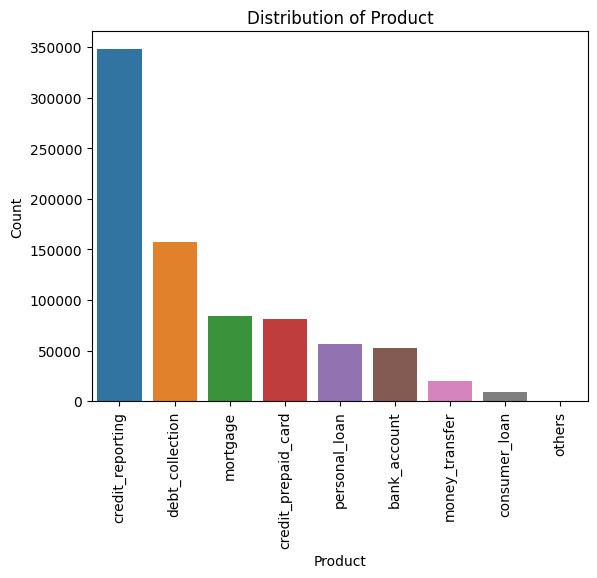

In [11]:
helper.create_bar_chart(df,'product',rotation=90)

## Cleaning text

In [12]:
patterns = [r'[Xx]{2,}', r"[^\w\d'\s]+", "\d+", ' +']
pattern_identifier = ['Dealing with consecutive Xs', 'Removing special characters apart from apostrophe', 'Replacing digits', 'Replacing double spaces with single ones']
df = helper.clean_text(df, text_col, patterns, pattern_identifier=pattern_identifier)

Dealing with consecutive Xs


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:27<00:00, 29720.83it/s]


Removing special characters apart from apostrophe


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:27<00:00, 29666.41it/s]


Replacing digits


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:16<00:00, 49812.13it/s]


Replacing double spaces with single ones


100%|███████████████████████████████████████████████████████████████████████| 809343/809343 [00:28<00:00, 28864.70it/s]


In [13]:
#loading pre-trained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

seq_len = 20

#tokenizing the text column
tokens = [tokenizer(i, padding="max_length", max_length=seq_len, 
                    truncation=True, return_tensors="pt") 
         for i in tqdm(df[text_col].tolist())]

#saving the tokens
helper.save_file(tokens_path, tokens)

100%|█████████████████████████████████████████████████████████████████████████| 809343/809343 [31:13<00:00, 432.07it/s]


In [13]:
tokens = helper.load_file(tokens_path)

## Model training prep

In [14]:
#encoding label
label_encoder = LabelEncoder()
label_encoder.fit(df[target_col])
labels = label_encoder.transform(df[target_col])

num_classes = len(label_encoder.classes_)
print(f'There are {num_classes} classes to predict')
#sanity checking
assert num_classes == len(df['product'].unique().tolist())

There are 9 classes to predict


In [15]:
#saving labels and label_encoder
helper.save_file(labels_path, labels)
helper.save_file(label_encoder_path, label_encoder)

In [16]:
data_loaders = data.create_dataloaders(tokens, labels,
                                       test_size=0.2, 
                                       valid_size=0.25, 
                                       random_state=42, 
                                       batch_size=16, 
                                       shuffle=False, 
                                       drop_last=False)

There are 485605 training data, and 161869 validation data, and 161869 testing data


In [17]:
#get loss function
loss = optimization.get_loss()

#initialize model
dropout = 0.5
distilbert_model = DistilBertClassifier(dropout, num_classes=num_classes, bert_model_name='distilbert-base-uncased')

#get optimizer
learning_rate = 1e-3
optimizer = 'adam'
optimizer = optimization.get_optimizer(distilbert_model, optimizer, learning_rate)
num_epochs = 3

## Model training

In [18]:
training.optimize(
    data_loaders,
    distilbert_model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    model_path=model_path,
    interactive_tracking=False
)

Validating: 100%|█████████████████████████| 10117/10117 [40:59<00:00,  4.11it/s]


Epoch: 1 	Training Loss: 1.253074 	Validation Loss: 1.120591
New minimum validation loss: 1.120591. Saving model ...


Validating: 100%|█████████████████████████| 10117/10117 [41:55<00:00,  4.02it/s]


Epoch: 2 	Training Loss: 1.225954 	Validation Loss: 1.115095


Validating: 100%|█████████████████████████| 10117/10117 [40:52<00:00,  4.13it/s]


Epoch: 3 	Training Loss: 1.225585 	Validation Loss: 1.097419
New minimum validation loss: 1.097419. Saving model ...


In [19]:
reloaded_model = DistilBertClassifier(dropout, num_classes=num_classes, bert_model_name='distilbert-base-uncased')

In [20]:
reloaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [22]:
test_loss = training.one_epoch_test(data_loaders['test'], reloaded_model, loss)

Testing: 100%|████████████████████████████| 10117/10117 [41:51<00:00,  4.03it/s]

Test Loss: 1.100121


Test Accuracy: 61.94% (100263.0/161869.0)
